In [51]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
import matplotlib.pyplot as plt
from slsim.ImageSimulation.image_simulation import (
    point_source_coordinate_properties,
    lens_image_series,
    rgb_image_from_image_list,
)
from slsim.Plots.plot_functions import create_image_montage_from_image_list

from taufit import fit_drw
from astropy import units as u
import corner

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lensed quasar population

This notebook shows how to simulate lensed quasar population with variability.

In [22]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=5, unit="deg2")
full_sky_area = Quantity(value=500, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

In [23]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=galaxy_sky_area, filters=None, cosmo=cosmo
)

In [24]:
# Initiate deflector popiulation class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/home/paras/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:56: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/home/paras/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:59: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [25]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

In [ ]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
}
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    point_source_type="quasar",
    point_source_kwargs=kwargs_quasar,
)

In [ ]:
# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Draw lenses

In [8]:
kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

## Select a lens to visualize

In [47]:
# Select a random lens
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [48]:
# Get a point source coordinate so that you can plot these image center in the plot.
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=35,
    delta_pix=0.2,
    num_pix=64,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

print(pix_coord)

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
[array([38.91772928, 34.21398927]), array([26.43653981, 30.03580118])]


## See the light curve of a selected quasar

In [49]:
time = np.linspace(-500, 1500, 500)

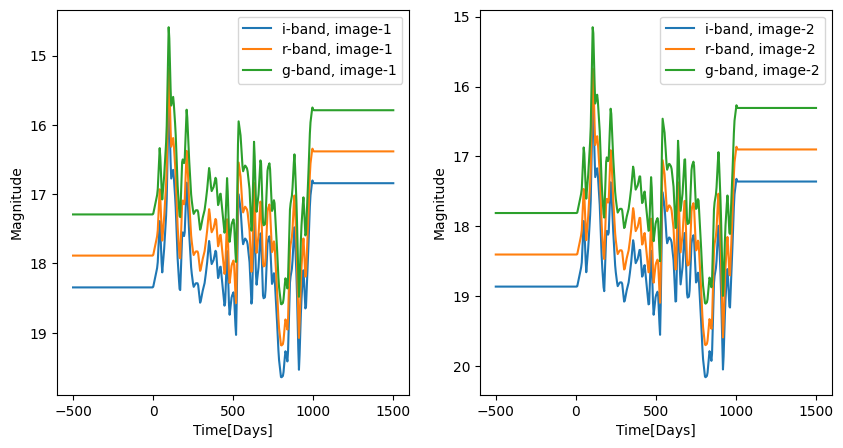

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="i", lensed=True, time=time)[0][0],
    label="i-band, image-1",
)
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="r", lensed=True, time=time)[0][0],
    label="r-band, image-1",
)
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="g", lensed=True, time=time)[0][0],
    label="g-band, image-1",
)
# ax1.gca().invert_yaxis()
ax1.set_ylabel("Magnitude")
ax1.set_xlabel("Time" "[Days]")
# ax1.set_xlim(0, 500)
# ax1.set_ylim(19.5, 21.25)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="i", lensed=True, time=time)[0][1],
    label="i-band, image-2",
)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="r", lensed=True, time=time)[0][1],
    label="r-band, image-2",
)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="g", lensed=True, time=time)[0][1],
    label="g-band, image-2",
)
# ax1.gca().invert_yaxis()
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Time" "[Days]")
# ax2.set_xlim(0, 250)
# ax2.set_ylim(None, 25)
ax2.invert_yaxis()
ax1.invert_yaxis()
ax1.legend()
ax2.legend()

## Set observation time and image configuration

In [51]:
time = np.linspace(0, 250, 10)
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = len(time)
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

## Simulate Image

In [52]:
# Simulate a lens image
image_lens_series_i = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_g = lens_image_series(
    lens_class=lens_class,
    band="g",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_r = lens_image_series(
    lens_class=lens_class,
    band="r",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)

In [53]:
rgb_image_list = []
for i in range(len(image_lens_series_i)):
    rgb_image_list.append(
        rgb_image_from_image_list(
            image_list=[
                image_lens_series_i[i],
                image_lens_series_r[i],
                image_lens_series_g[i],
            ],
            stretch=0.5,
        )
    )

## Visualize simulated images

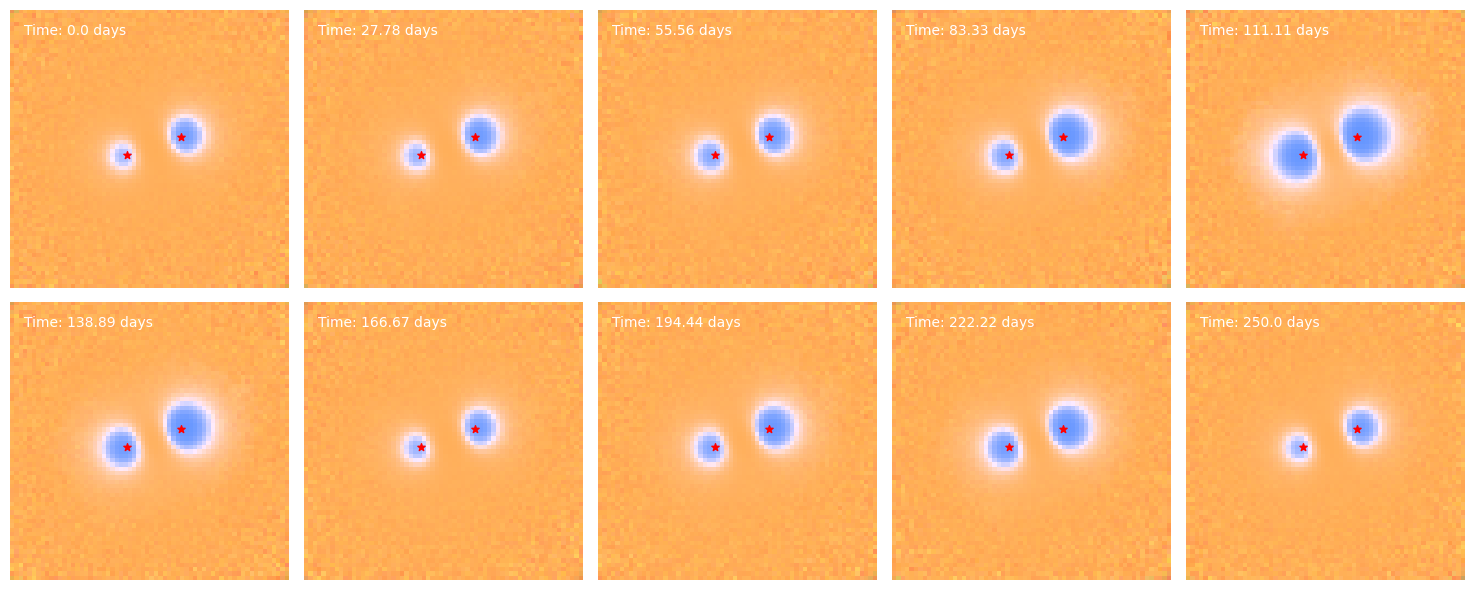

In [54]:
plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=rgb_image_list, time=time, image_center=pix_coord
)

## EXTRA: Lensed Quasar population with variability parameters drawn from realistic distribution (MacLeod et al. 2010)

In [26]:
#############################################################################
# Distributions from MacLeod+2010 for Quasar AGN variability parameters
# means and covariances for the log(BH_mass/Msun), M_i, log(SFi_inf/mag), log(tau/days), zsrc
MACLEOD2010_MEANS = np.array(
    [8.53308079, -23.48721021, -0.51665998, 2.28708691, 2.11640976]
)
MACLEOD2010_COV = np.array(
    [
        [0.27862905, -0.29501766, 0.00675703, 0.04606804, -0.00665875],
        [-0.29501766, 2.06855169, 0.19690851, 0.0244139, -0.29913764],
        [0.00675703, 0.19690851, 0.02785685, 0.01083628, -0.02216221],
        [0.04606804, 0.0244139, 0.01083628, 0.05636087, -0.02716507],
        [-0.00665875, -0.29913764, -0.02216221, -0.02716507, 0.3077278],
    ]
)
#############################################################################


# Prepare dictionary of agn variability kwargs
# Note: the means array and covariance matrix should be defined in following order and units:
# log(BH_mass/Msun), M_i, log(SFi_inf/mag), log(tau/days), zsrc
variable_agn_kwarg_dict = {
    "multivariate_gaussian_means": MACLEOD2010_MEANS,
    "multivariate_gaussian_covs": MACLEOD2010_COV,
    "known_band": "lsst2016-i",
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law_from_distribution",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
    "corona_height": 10,
    "r_resolution": 500,
}

# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    point_source_type="quasar",
    point_source_kwargs=kwargs_quasar,
)

# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Draw lenses
kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

In [31]:
# select two random lenses and see if quasars variability parameters are different or not?
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}

for i in range(2):
    lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

    # run point source magnitude function to get variability parameters assigned
    _ = lens_class.point_source_magnitude(
        band="i", lensed=True, time=np.linspace(0, 10, 1000)
    )
    print("\n")

    # print the variability parameters
    print(f" ========= LENS {i+1} ========= ")
    print(
        "Variability Model: ",
        lens_class.source(0)._source.agn_class.agn_driving_variability_model,
    )
    print(
        "Variability Parameters: ",
        lens_class.source(0)._source.agn_class.agn_driving_kwargs_variability,
    )

/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)




 ========= LENS 1 ========= 
Variability Model:  bending_power_law
Variability Parameters:  {'length_of_light_curve': np.float64(1000.0), 'time_resolution': 1, 'log_breakpoint_frequency': np.float64(-3.3687146380882704), 'low_frequency_slope': 0, 'high_frequency_slope': 2, 'standard_deviation': np.float64(0.39323127235795075)}


/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)




 ========= LENS 2 ========= 
Variability Model:  bending_power_law
Variability Parameters:  {'length_of_light_curve': np.float64(1000.0), 'time_resolution': 1, 'log_breakpoint_frequency': np.float64(-3.3288295512591506), 'low_frequency_slope': 0, 'high_frequency_slope': 2, 'standard_deviation': np.float64(0.5596322040204953)}


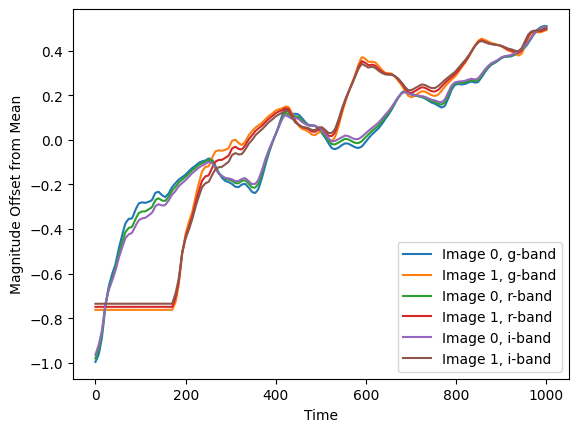

In [40]:
# Verify that the SF and Tau are different for different bands

lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

snapshot_times = np.linspace(0, 1000, 1000)
ps_mags = {}
ps_mags_err = {}
for band in ["g", "r", "i"]:
    ps_mags[band] = lens_class.point_source_magnitude(
        band=band, lensed=True, time=snapshot_times
    )[0]
    ps_mags_err[band] = ps_mags[band] * 0.01

for band in ["g", "r", "i"]:
    for image in range(lens_class.image_number[0]):
        plt.plot(
            snapshot_times,
            # ps_mags[band][image],
            ps_mags[band][image] - np.mean(ps_mags[band][image]),
            label=f"Image {image}, {band}-band",
        )

plt.xlabel("Time")
plt.ylabel("Magnitude Offset from Mean")
plt.legend()
plt.show()

In [41]:
for band in ["i", "r", "g"]:
    gp, samples, _ = fit_drw(
        snapshot_times * u.day,
        ps_mags[band][0] * u.mag,
        ps_mags_err[band][0] * u.mag,
        plot=False,
        verbose=False,
    )
    log_tau_drw_recovered = np.log10(1 / np.exp(np.median(samples[:, 1])))
    log_sf_drw_recovered = np.log10(np.sqrt(np.exp(np.median(samples[:, 0])) / 2))
    print(
        "Band: ",
        band,
        ";  log(tau): ",
        log_tau_drw_recovered,
        ";  log(SF): ",
        log_sf_drw_recovered,
    )

/home/paras/.venv/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Band:  i ;  log(tau):  3.5704706482175483 ;  log(SF):  -0.4126189509929929
Band:  r ;  log(tau):  3.507545456116112 ;  log(SF):  -0.41661298469226293
Band:  g ;  log(tau):  3.5146113047572065 ;  log(SF):  -0.3851036100243244


We find very slight difference in SF and Tau across the optical bands for some of the selected lenses! But for most, the difference is miniscule.

In [42]:
# for all the lenses in the quasar_lens_population, generate lightcurves
# then get SF and Tau for each quasar source.

SFs = []
Taus = []
for lens_class in quasar_lens_population:

    # run point source magnitude function to get variability parameters assigned
    _ = lens_class.point_source_magnitude(
        band="i", lensed=True, time=np.linspace(0, 10, 1000)
    )

    kwargs_variability = lens_class.source(0)._source.agn_class.agn_driving_kwargs_variability
    std = kwargs_variability['standard_deviation']
    log_bp_freq = kwargs_variability['log_breakpoint_frequency']

    SFs.append(np.sqrt(2)*std)
    Taus.append(1/(2*np.pi*10**log_bp_freq))

/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [54]:
# plot SF and Tau

data = np.vstack([np.log10(Taus), np.log10(SFs)]).T

labels = [r"$\log (\tau/days)$", r"$\log (SF_{\\infty}/mag)$"]

fig = corner.corner(
    data, 
    labels=labels,
    show_titles=True,     
    plot_datapoints=True, 
    smooth = 1.0
)

plt.show()

ValueError: 
\log (SF_{\\infty}/mag)
          ^
ParseSyntaxException: Expected end_group, found '\'  (at char 10), (line:1, col:11)

<Figure size 550x550 with 4 Axes>